In [ ]:
from google.colab import files
files.upload()
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d preetviradiya/brian-tumor-dataset
!unzip brian-tumor-dataset.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 98% 105M/107M [00:07<00:00, 19.8MB/s]
100% 107M/107M [00:07<00:00, 14.8MB/s]
Archive:  brian-tumor-dataset.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer

In [ ]:
import os

os.makedirs('test_data', exist_ok=True)

os.makedirs('test_data/Brain Tumor', exist_ok=True)
os.makedirs('test_data/Healthy', exist_ok=True)


In [ ]:
import shutil
from random import sample

def move_to_test(class_dir, test_dir, percentage=0.1):
    images = os.listdir(class_dir)
    n_test = int(len(images) * percentage)

    test_images = sample(images, n_test)

    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_dir, image))

# Rutas de los directorios de datos originales
original_tumor_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
original_healthy_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

# Rutas de los directorios de prueba
test_tumor_dir = '/content/test_data/Brain Tumor'
test_healthy_dir = '/content/test_data/Healthy'

# Mueve las imágenes
move_to_test(original_tumor_dir, test_tumor_dir, percentage=0.1)
move_to_test(original_healthy_dir, test_healthy_dir, percentage=0.1)


n_tumor_images = len(os.listdir(original_tumor_dir))
n_healthy_images = len(os.listdir(original_healthy_dir))

print("Número de imágenes de tumor cerebral en el conjunto de entrenamiento:", n_tumor_images)
print("Número de imágenes saludables en el conjunto de entrenamiento:", n_healthy_images)



Número de imágenes de tumor cerebral en el conjunto de entrenamiento: 2262
Número de imágenes saludables en el conjunto de entrenamiento: 1879


In [ ]:
print("Imágenes en el directorio de prueba para 'Brain Tumor':", len(os.listdir(test_tumor_dir)))
print("Imágenes en el directorio de prueba para 'Healthy':", len(os.listdir(test_healthy_dir)))




Imágenes en el directorio de prueba para 'Brain Tumor': 251
Imágenes en el directorio de prueba para 'Healthy': 208


In [ ]:
!ls
!ls Brain\ Tumor\ Data\ Set

'Brain Tumor Data Set'	   kaggle.json	  metadata_rgb_only.csv   test_data
 brian-tumor-dataset.zip   metadata.csv   sample_data
'Brain Tumor Data Set'


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

In [ ]:
import cv2
import glob
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_process_images(path, size=(224, 224)):
    images = []
    for filename in glob.iglob(path):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img)
            images.append(img)
    return images

path_tumor_training = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/*.jpg'
tumor_images = load_and_process_images(path_tumor_training)

path_healthy_brain = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/*.jpg'
healthy_images = load_and_process_images(path_healthy_brain)

print("Total de imágenes de tumor:", len(tumor_images))
print("Total de imágenes saludables:", len(healthy_images))

if tumor_images:
    print("Dimensiones de una imagen de tumor:", tumor_images[0].shape)
if healthy_images:
    print("Dimensiones de una imagen saludable:", healthy_images[0].shape)



Total de imágenes de tumor: 2126
Total de imágenes saludables: 1866
Dimensiones de una imagen de tumor: (224, 224, 3)
Dimensiones de una imagen saludable: (224, 224, 3)


In [ ]:

healthy_images = np.array(healthy_images)
tumor_images = np.array(tumor_images)
all_images = np.concatenate([tumor_images, healthy_images])

print("Shape de healthy_images:", healthy_images.shape)
print("Shape de tumor_images:", tumor_images.shape)


Shape de healthy_images: (1866, 224, 224, 3)
Shape de tumor_images: (2126, 224, 224, 3)


# Visualization

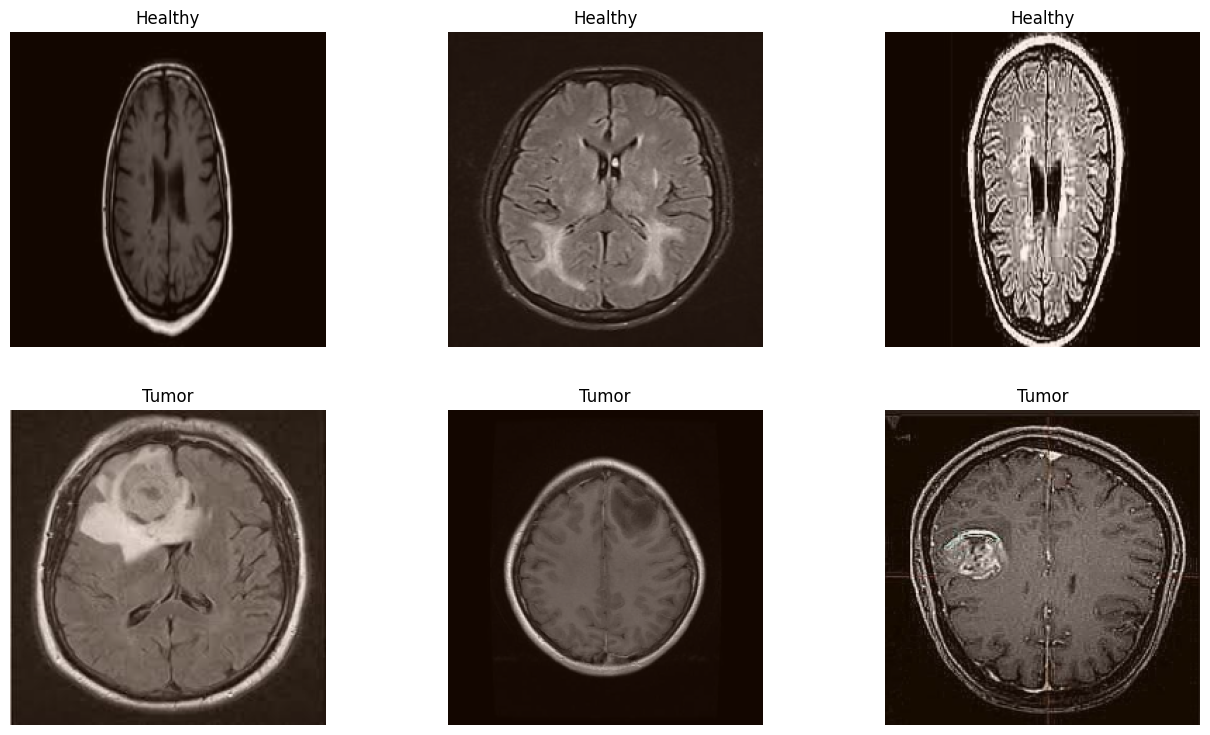

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def random_plot(healthy_images, tumor_images, num=3):
    plt.figure(figsize=(16, 9))
    indices_healthy = np.random.choice(len(healthy_images), num, replace=False)
    indices_tumor = np.random.choice(len(tumor_images), num, replace=False)

    for i, idx in enumerate(indices_healthy):
        plt.subplot(2, num, i+1)
        img = healthy_images[idx]
        img_display = (img - img.min()) / (img.max() - img.min())  # Normalizar a [0, 1]
        plt.imshow(img_display)
        plt.title('Healthy')
        plt.axis('off')

    for i, idx in enumerate(indices_tumor):
        plt.subplot(2, num, num+i+1)
        img = tumor_images[idx]
        img_display = (img - img.min()) / (img.max() - img.min())  # Normalizar a [0, 1]
        plt.imshow(img_display)
        plt.title('Tumor')
        plt.axis('off')

    plt.show()

random_plot(healthy_images, tumor_images)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

labels_tumor = np.ones(len(tumor_images))
labels_healthy = np.zeros(len(healthy_images))

all_images = np.concatenate([tumor_images, healthy_images])
all_labels = np.concatenate([labels_tumor, labels_healthy])

X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")



X_train shape: (3193, 224, 224, 3)
X_val shape: (799, 224, 224, 3)
y_train shape: (3193,)
y_val shape: (799,)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Regularización L2
x = Dropout(0.5)(x)  # Dropout
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

history = model.fit(train_generator, epochs=10, validation_data=(X_val, y_val))


94765736/94765736 [==============================] - 5s 0us/step


Epoch 1/10
100/100 [==============================] - 61s 505ms/step - loss: 4.9904 - accuracy: 0.8328 - val_loss: 1.5111 - val_accuracy: 0.9237
Epoch 2/10
100/100 [==============================] - 45s 447ms/step - loss: 1.0504 - accuracy: 0.8960 - val_loss: 0.6675 - val_accuracy: 0.9312
Epoch 3/10
100/100 [==============================] - 43s 426ms/step - loss: 0.6544 - accuracy: 0.8832 - val_loss: 0.4800 - val_accuracy: 0.9387
Epoch 4/10
100/100 [==============================] - 41s 414ms/step - loss: 0.4947 - accuracy: 0.9013 - val_loss: 0.3859 - val_accuracy: 0.9449
Epoch 5/10
100/100 [==============================] - 41s 414ms/step - loss: 0.4488 - accuracy: 0.8970 - val_loss: 0.3455 - val_accuracy: 0.9474
Epoch 6/10
100/100 [==============================] - 43s 434ms/step - loss: 0.4390 - accuracy: 0.8913 - val_loss: 0.3354 - val_accuracy: 0.9237
Epoch 7/10
100/100 [==============================] - 43s 429ms/step - loss: 0.4060 - accuracy: 0.9007 - val_loss: 0.2997 - val_ac

In [ ]:
import plotly.graph_objects as go

# Extraer los datos de precisión y pérdida del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(epochs), y=acc, mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_acc, mode='lines+markers', name='Validation Accuracy'))

fig.add_trace(go.Scatter(x=list(epochs), y=loss, mode='lines+markers', name='Training Loss', yaxis='y2'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_loss, mode='lines+markers', name='Validation Loss', yaxis='y2'))

fig.update_layout(
    title='Training and Validation Accuracy and Loss',
    xaxis_title='Epoch',
    yaxis=dict(title='Accuracy', titlefont=dict(color='blue'), tickfont=dict(color='blue')),
    yaxis2=dict(title='Loss', titlefont=dict(color='red'), tickfont=dict(color='red'), overlaying='y', side='right'),
    legend=dict(x=0.1, y=1.1, orientation='h'))

fig.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_random_images(X_val, y_val, model, num_images=5):
    indices = np.random.choice(len(X_val), num_images, replace=False)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(indices):
        img = X_val[idx]
        true_label = y_val[idx]
        img_expanded = np.expand_dims(img, axis=0)
        prediction = model.predict(img_expanded)[0][0]

        axs[i].imshow(img.astype(np.uint8))
        axs[i].title.set_text(f'Pred: {"Healthy" if prediction < 0.5 else "Tumor"}\nTrue: {"Healthy" if true_label == 0 else "Tumor"}')
        axs[i].axis('off')

    plt.show()



1/1 [==============================] - 0s 22ms/step


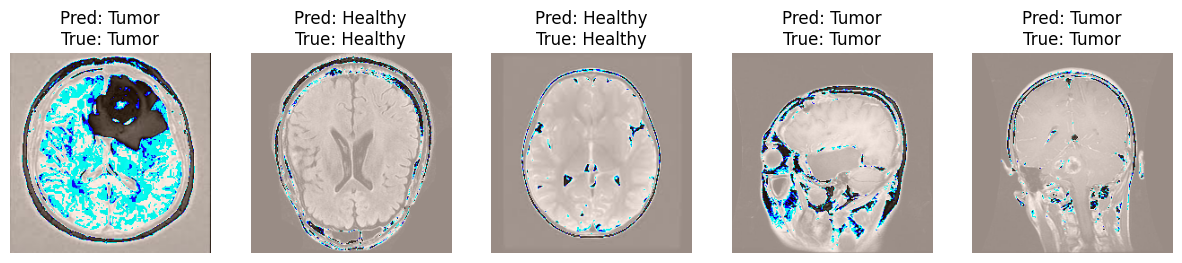

In [ ]:
predict_random_images(X_val, y_val, model, num_images=5)


In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow as tf

full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]

tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./",
                  name="frozen_graph.pb",
                  as_text=False)

with open('labels.txt', 'w') as f:
    f.write('\n'.join(['tumor', 'healthy']))

In [ ]:
from google.colab import files

# Asegúrate de especificar la ruta correcta donde se guardó el archivo
files.download('frozen_graph.pb')
files.download('labels.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>